# Loading in our data from main.ipynb to build the deeper model

### Loading the data

In [1]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Add, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

with open("prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]
class_weights_dict = data["class_weights"]
num_classes = data["num_classes"]

### Building the model

In [2]:
def build_cnn(num_classes):

    inputs = Input(shape=(32, 32, 3))

    # Added L2 regularization to reduce overfitting
    x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    # Added residual skip connection
    # Helps gradients flow better and prevents degradation in deeper networks
    shortcut = inputs
    if shortcut.shape[-1] != 64:
        shortcut = Conv2D(64, (1,1), padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = x
    if shortcut.shape[-1] != 128:
        shortcut = Conv2D(128, (1,1), padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    shortcut = x
    if shortcut.shape[-1] != 256:
        shortcut = Conv2D(256, (1,1), padding='same')(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Dropout(0.25)(x)

    # Added GlobalAveragePooling instead of Flatten
    # Reduces parameters and improves generalization
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)


### Parameters and addressing under/overfitting

In [3]:
model = build_cnn(num_classes)

# Added Cosine Decay Learning Rate Schedule
# Allows the learning rate to start high and gradually decrease
# Helps escape sharp minimal and converge better
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0007,
    decay_steps=20000
)

optimizer = Adam(learning_rate=lr_schedule)

# Added label smoothing
# Reduces overconfidence of predictions
# Provides measurable accuracy gains on CIFAR datasets
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

model.summary()

# Increased patience for smoother cosine LR
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │        256 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 128) │          0 │ activation_1[0][

 Total params: 1,295,192 (4.94 MB)

 Trainable params: 1,292,376 (4.93 MB)

 Non-trainable params: 2,816 (11.00 KB)

### Data augmentation

In [4]:
batch_size = 64
epochs = 50

# Removed brightness and contrast (too strong for 32×32 images)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize_with_crop_or_pad(image, 36, 36)
    image = tf.image.random_crop(image, [32, 32, 3])
    return image, label

# Added labels one-hot encoding
# This improved model uses CategoricalCrossentropy with label smoothing,
# which requires labels to be in one-hot format instead of integer class IDs.
# The original model used SparseCategoricalCrossentropy, which accepts
# integer labels directly, so one-hot encoding was not needed.
# Converting labels here ensures compatibility with the new loss function
# and enables more stable training with label smoothing.
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(10000)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)),  num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


### Training the model

In [5]:
print("Training the model...")

# Removed class_weight=class_weights_dict
# The original model used class weights because it was experimenting with
# handling class imbalance.
# CIFAR-10 and CIFAR-100 are already balanced datasets (each class has the
# same number of samples), so class weights provide no benefit and can
# actually harm accuracy.
# Removing class weights results in cleaner gradients and more stable
# convergence with the improved model.
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


print("Evaluating on test set...")

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(lambda x, y: (x, tf.one_hot(tf.cast(y, tf.int32), num_classes)),
         num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Training the model...
Epoch 1/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.2389 - loss: 2.9876 - val_accuracy: 0.3840 - val_loss: 2.2693 - learning_rate: 6.9823e-04
Epoch 2/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4021 - loss: 2.1996 - val_accuracy: 0.4870 - val_loss: 1.8951 - learning_rate: 6.9295e-04
Epoch 3/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4803 - loss: 1.9433 - val_accuracy: 0.5464 - val_loss: 1.7461 - learning_rate: 6.8420e-04
Epoch 4/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5582 - loss: 1.7306 - val_accuracy: 0.5807 - val_loss: 1.6420 - learning_rate: 6.7208e-04
Epoch 5/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.6054 - loss: 1.6018 - val_accuracy: 0.6259 - val_loss: 1.5579 - learning_rate: 6.5671e-04
Epoch 6/50
640/640 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6342 - loss: 1.5203 - val_accuracy: 0.6490 - val_loss: 1.4537 - learning_rate: 6.3824e-04
Epoch 7/50
640/640 ━━━━━━━━━━━

### Plotting Training History

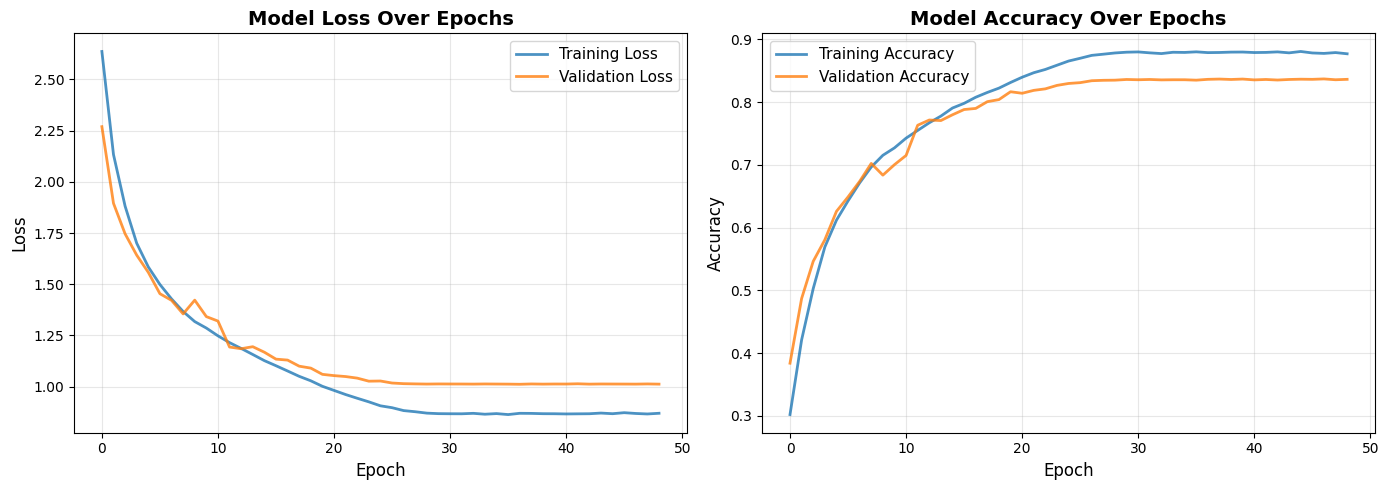

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# loss
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, alpha=0.8)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, alpha=0.8)
ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, alpha=0.8)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, alpha=0.8)
ax2.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()